In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import sagemaker
import os
import re
import numpy as np
import json
import matplotlib.pyplot as plt
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import seaborn as sns
import helpers
import sklearn.model_selection
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()


In [3]:
ltc_df = pd.read_csv('Data/ltc.csv')

In [4]:
ltc_3yr_df = ltc_df[1862:]

In [5]:
ltc_3yr_df = ltc_3yr_df.drop(labels='date', axis=1)

In [6]:
ltc_3yr_df.index = np.arange(len(ltc_3yr_df))

In [7]:
ltc_3yr_df.insert(39, 'Label', 0.0)

In [8]:
for i in range(len(ltc_3yr_df)):
    if i < (len(ltc_3yr_df)-1):
        ltc_3yr_df['Label'][i] = ltc_3yr_df['PriceUSD'][i+1]
    else:
        ltc_3yr_df['Label'][i] = ltc_3yr_df['PriceUSD'][i]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
ltc_3yr_df.head()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Label
0,7301,638,1962084,3075.366771,0.657791,1.844730e+08,2.804431e+08,53827.569370,0.006044,0.023037,...,147.744617,563.151417,0.616035,2.348112,1.310052e+06,4.993464e+06,0.029249,0.016593,0.012424,3.747908
1,10630,576,2417247,4196.609375,0.647167,1.814419e+08,2.803635e+08,53827.569370,0.007412,0.027780,...,233.870536,876.525329,0.159891,0.599259,2.545915e+06,9.541855e+06,0.029240,0.016358,0.012601,3.888318
2,15468,561,2550985,4547.210339,0.671392,1.882939e+08,2.804530e+08,57164.083717,0.004974,0.019340,...,339.766758,1321.121208,0.013982,0.054368,6.012513e+06,2.337856e+07,0.029359,0.017770,0.013482,3.864308
3,13481,605,2800901,4629.588430,0.667102,1.871896e+08,2.806010e+08,58578.291575,0.006038,0.023331,...,234.939070,907.877015,0.028395,0.109729,3.063840e+06,1.183962e+07,0.029357,0.017801,0.013501,3.898460
4,10544,588,2694323,4582.181973,0.673017,1.889013e+08,2.806781e+08,58578.291575,0.004643,0.018100,...,392.344821,1529.540788,0.500000,1.949230,4.390339e+06,1.711556e+07,0.029131,0.017859,0.013542,3.909259


In [10]:
Y_df = pd.DataFrame(ltc_3yr_df['Label'])
X_df = pd.DataFrame(ltc_3yr_df.drop(labels='Label', axis=1))

In [14]:
def get_test_loss(pred, test):
    test_loss = 0
    test.index = np.arange(len(pred))
    for i in range(len(pred)):
        test_loss += np.absolute(pred[0][i] - test['Label'][i])
    test_loss = test_loss/len(pred)
    print('Test loss is {}.'.format(test_loss))

# Hyperameter tuner with 110 day validation and test sets

In [16]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.111, shuffle=False)

In [17]:
len(Y_val)

110

In [18]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'
assert X_test['PriceUSD'][999] == Y_test['Label'][998], \
    'Test values aren\'t matching'
assert X_train['PriceUSD'][22] == Y_train['Label'][21], \
    'Train values aren\'t matching'

print('Tests Passed!')    

Tests Passed!


In [19]:
data_dir = 'Data/ltc_3yr_hypertuner'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [20]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [21]:
prefix = 'ltc-xgboost-tuning'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [22]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [23]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In [24]:
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [25]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [26]:
xgb_hyperparameter_tuner.wait()

...............................................................................................................................................................................................................................................................................................................!


In [27]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-191224-1427-010-8bc0568a'

In [28]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2019-12-24 14:42:01 Starting - Preparing the instances for training
2019-12-24 14:42:01 Downloading - Downloading input data
2019-12-24 14:42:01 Training - Training image download completed. Training in progress.
2019-12-24 14:42:01 Uploading - Uploading generated training model
2019-12-24 14:42:01 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[14:41

In [29]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [30]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [31]:
xgb_transformer.wait()

.....................[2019-12-24 15:07:51 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2019-12-24 15:07:51 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-12-24 15:07:51 +0000] [15] [INFO] Using worker: gevent
[2019-12-24 15:07:51 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-24 15:07:51 +0000] [26] [INFO] Booting worker with pid: 26
[2019-12-24 15:07:51 +0000] [27] [INFO] Booting worker with pid: 27
[2019-12-24 15:07:51 +0000] [28] [INFO] Booting worker with pid: 28
[2019-12-24:15:08:28:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [24/Dec/2019:15:08:28 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-24:15:08:28:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [24/Dec/2019:15:08:28 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-24:15:08:28:INFO] No GPUs detected (normal if no gpus installed)
[2019-12-24:15:08:28:INFO] Determined delimiter of CSV i

In [32]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-191224-1427-010-8bc05-2019-12-24-15-04-26-706/test.csv.out to Data/ltc_3yr_hypertuner/test.csv.out


In [33]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

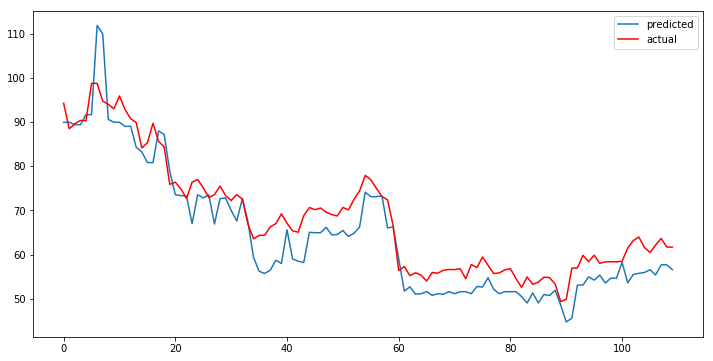

In [34]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.legend()
plt.show()

In [35]:
def get_test_loss(pred, test):
    test_loss = 0
    test.index = np.arange(len(pred))
    for i in range(len(pred)):
        test_loss += np.absolute(pred[0][i] - test['Label'][i])
    test_loss = test_loss/len(pred)
    print('Test loss is {}.'.format(test_loss))

In [36]:
get_test_loss(Y_pred, Y_test)

Test loss is 4.611637919752981.


In [37]:
def roi_display(initial_investment, predictions, actual, transaction_rate=0, buy_threshold=0,\
    sell_threshold=0):
    """Returns total return on investment through the following inputs:
    - initial_investment: initial dollar amount to be invested
    - predictions: numpy array of EOD stock price predictions from xgboost model
    - actual: numpy array of actual end of day stock prices
    - transaction_rate: rate to be charged each time transaction is made
    - buy_threshold: prediction percentage of growth before executing buying
        transaction
    - sell_threshold: prediction percentage of loss before executing selling
        transaction
    """

    investing = 0
    holding = initial_investment
    predictions = predictions[0]
    actual = actual['Label']
    actual.index = np.arange(len(predictions))
    
    for i in range(len(predictions)-1):
        if holding > 0:
            if predictions[i+1]*(1-buy_threshold) > predictions[i]:
                investing = (holding*(1-transaction_rate)) / actual[i]
                print('Investing ${:.2f}'.format(holding - initial_investment))
                holding = 0         
        if investing > 0:
            if predictions[i+1]*(1+sell_threshold) < predictions[i]:
                holding = (investing * actual[i])*(1-transaction_rate)
                investing = 0
                print('Holding ${:.2f}'.format(holding - initial_investment))

    if holding > 0:
        print('Total return on investment before taxes is ${:.2f}'.format(\
        holding - initial_investment))
    else:
        print('Total return on investment before taxes is ${:.2f}'.format(\
            investing * actual[361] - initial_investment))

In [38]:
roi_display(20000, Y_pred, Y_test)

Investing $0.00
Holding $1858.57
Investing $1858.57
Holding $854.57
Investing $854.57
Holding $1021.31
Investing $1021.31
Holding $395.66
Investing $395.66
Holding $335.14
Investing $335.14
Holding $55.06
Investing $55.06
Holding $877.87
Investing $877.87
Holding $235.88
Investing $235.88
Holding $771.85
Investing $771.85
Holding $494.65
Investing $494.65
Holding $971.98
Investing $971.98
Holding $3311.74
Investing $3311.74
Holding $2735.02
Investing $2735.02
Holding $903.41
Investing $903.41
Holding $143.96
Investing $143.96
Holding $-524.99
Investing $-524.99
Holding $-581.16
Investing $-581.16
Holding $-523.96
Investing $-523.96
Holding $-1230.15
Investing $-1230.15
Holding $-1456.78
Investing $-1456.78
Holding $-2044.61
Investing $-2044.61
Holding $-2454.36
Investing $-2454.36
Holding $-2981.63
Investing $-2981.63
Holding $-2627.43
Investing $-2627.43
Holding $-3083.58
Investing $-3083.58
Holding $-177.63
Investing $-177.63
Holding $-793.79
Investing $-793.79
Holding $-751.81
Inves

# Hyperparameter Tuning with 30 day validation set

In [49]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.03, shuffle=False)

In [53]:
len(Y_val)

30

In [54]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'
assert X_test['PriceUSD'][999] == Y_test['Label'][998], \
    'Test values aren\'t matching'
assert X_train['PriceUSD'][22] == Y_train['Label'][21], \
    'Train values aren\'t matching'

print('Tests Passed!')    

Tests Passed!


In [55]:
data_dir = 'Data/ltc_3yr_hypertuner_30d_val'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [56]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [57]:
prefix = 'ltc-xgboost-tuning'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [58]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [59]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In [60]:
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [61]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [62]:
xgb_hyperparameter_tuner.wait()

.........................................................................................................................................................................................................................................................................................................!


In [63]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-191224-1518-019-9fd2d3b5'

In [64]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2019-12-24 15:43:20 Starting - Preparing the instances for training
2019-12-24 15:43:20 Downloading - Downloading input data
2019-12-24 15:43:20 Training - Training image download completed. Training in progress.
2019-12-24 15:43:20 Uploading - Uploading generated training model
2019-12-24 15:43:20 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[15:43

In [65]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [66]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [67]:
xgb_transformer.wait()

......................[2019-12-24 15:47:27 +0000] [17] [INFO] Starting gunicorn 19.10.0
[2019-12-24 15:47:27 +0000] [17] [INFO] Listening at: unix:/tmp/gunicorn.sock (17)
[2019-12-24 15:47:27 +0000] [17] [INFO] Using worker: gevent
[2019-12-24 15:47:27 +0000] [24] [INFO] Booting worker with pid: 24
[2019-12-24 15:47:27 +0000] [25] [INFO] Booting worker with pid: 25
[2019-12-24 15:47:27 +0000] [29] [INFO] Booting worker with pid: 29
[2019-12-24 15:47:27 +0000] [33] [INFO] Booting worker with pid: 33
[2019-12-24:15:47:49:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [24/Dec/2019:15:47:49 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-24:15:47:49:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [24/Dec/2019:15:47:49 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-24:15:47:49:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [24/Dec/2019:15:47:49 +0000] "POST /invoc

In [68]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-191224-1518-019-9fd2d-2019-12-24-15-44-07-729/test.csv.out to Data/ltc_3yr_hypertuner_30d_val/test.csv.out


In [69]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

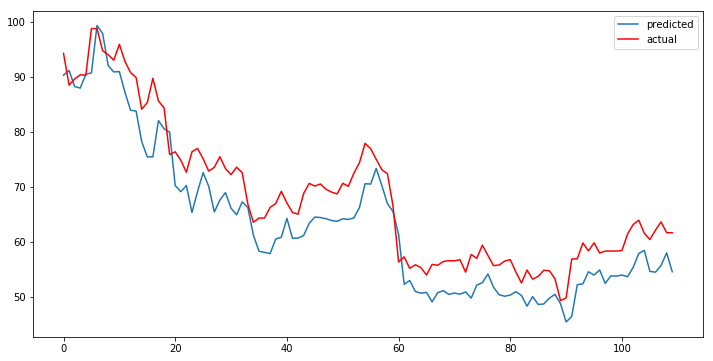

In [70]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.legend()
plt.show()

In [73]:
get_test_loss(Y_pred, Y_test)

Test loss is 5.245484510037992.


In [74]:
roi_display(20000, Y_pred, Y_test)

Investing $0.00
Holding $-1227.08
Investing $-1227.08
Holding $517.45
Investing $517.45
Holding $1157.12
Investing $1157.12
Holding $185.33
Investing $185.33
Holding $-402.98
Investing $-402.98
Holding $-727.96
Investing $-727.96
Holding $-785.15
Investing $-785.15
Holding $-1049.80
Investing $-1049.80
Holding $-818.98
Investing $-818.98
Holding $590.46
Investing $590.46
Holding $1172.33
Investing $1172.33
Holding $3534.44
Investing $3534.44
Holding $2939.22
Investing $2939.22
Holding $2105.80
Investing $2105.80
Holding $1571.06
Investing $1571.06
Holding $1772.02
Investing $1772.02
Holding $1756.12
Investing $1756.12
Holding $888.49
Investing $888.49
Holding $822.86
Investing $822.86
Holding $92.01
Investing $92.01
Holding $-511.78
Investing $-511.78
Holding $-661.27
Investing $-661.27
Holding $2660.79
Investing $2660.79
Holding $1956.41
Investing $1956.41
Holding $1966.17
Investing $1966.17
Holding $2014.71
Investing $2014.71
Holding $2064.71
Investing $2064.71
Holding $1897.86
Total

# Hyperparameter Tuning with Shuffled Training and Validation Sets

In [83]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.091, shuffle=True)

In [84]:
len(Y_val)

90

In [85]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'
assert X_test['PriceUSD'][999] == Y_test['Label'][998], \
    'Test values aren\'t matching'
assert X_train['PriceUSD'][22] == Y_train['Label'][21], \
    'Train values aren\'t matching'

print('Tests Passed!')    

Tests Passed!


In [86]:
data_dir = 'Data/ltc_3yr_hypertuner_90d_shuffled_val'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [87]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [88]:
prefix = 'ltc-xgboost-tuning'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [89]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [90]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In [91]:
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [92]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [93]:
xgb_hyperparameter_tuner.wait()

..........................................................................................................................................................................................................................................................................................................!


In [94]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-191224-1550-003-460c6617'

In [95]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2019-12-24 15:53:42 Starting - Preparing the instances for training
2019-12-24 15:53:42 Downloading - Downloading input data
2019-12-24 15:53:42 Training - Training image download completed. Training in progress.
2019-12-24 15:53:42 Uploading - Uploading generated training model
2019-12-24 15:53:42 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[15:53

In [96]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [97]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [98]:
xgb_transformer.wait()

.........................[2019-12-24 16:19:43 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2019-12-24 16:19:43 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-12-24 16:19:43 +0000] [15] [INFO] Using worker: gevent
[2019-12-24 16:19:43 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-24 16:19:43 +0000] [23] [INFO] Booting worker with pid: 23
[2019-12-24 16:19:43 +0000] [27] [INFO] Booting worker with pid: 27
[2019-12-24 16:19:43 +0000] [28] [INFO] Booting worker with pid: 28

[2019-12-24:16:20:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [24/Dec/2019:16:20:15 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-24:16:20:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [24/Dec/2019:16:20:15 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-24:16:20:15:INFO] No GPUs detected (normal if no gpus installed)
[2019-12-24:16:20:15:INFO] Determined delimiter of 

In [99]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-191224-1550-003-460c6-2019-12-24-16-15-49-778/test.csv.out to Data/ltc_3yr_hypertuner_90d_shuffled_val/test.csv.out


In [100]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

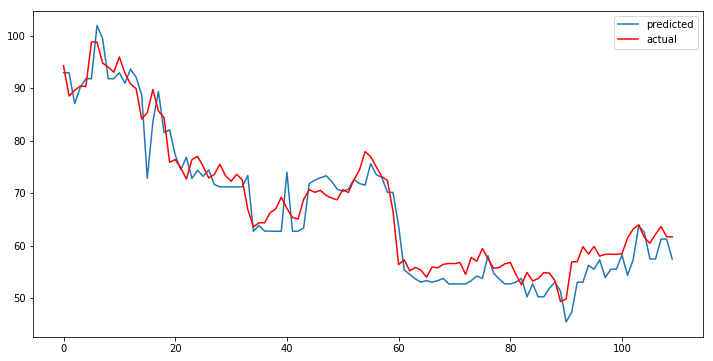

In [101]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.legend()
plt.show()

In [102]:
get_test_loss(Y_pred, Y_test)

Test loss is 3.011071809254127.


In [103]:
def roi_display(initial_investment, predictions, actual, transaction_rate=0, buy_threshold=0,\
    sell_threshold=0):
    """Returns total return on investment through the following inputs:
    - initial_investment: initial dollar amount to be invested
    - predictions: numpy array of EOD stock price predictions from xgboost model
    - actual: numpy array of actual end of day stock prices
    - transaction_rate: rate to be charged each time transaction is made
    - buy_threshold: prediction percentage of growth before executing buying
        transaction
    - sell_threshold: prediction percentage of loss before executing selling
        transaction
    """

    investing = 0
    holding = initial_investment
    predictions = predictions[0]
    actual = actual['Label']
    actual.index = np.arange(len(predictions))
    
    for i in range(len(predictions)-1):
        if holding > 0:
            if predictions[i+1]*(1-buy_threshold) > predictions[i]:
                investing = (holding*(1-transaction_rate)) / actual[i]
                print('Investing ${:.2f}'.format(holding - initial_investment))
                holding = 0         
        if investing > 0:
            if predictions[i+1]*(1+sell_threshold) < predictions[i]:
                holding = (investing * actual[i])*(1-transaction_rate)
                investing = 0
                print('Holding ${:.2f}'.format(holding - initial_investment))

    if holding > 0:
        print('Total return on investment before taxes is ${:.2f}'.format(\
        holding - initial_investment))
    else:
        print('Total return on investment before taxes is ${:.2f}'.format(\
            investing * actual[361] - initial_investment))

In [104]:
roi_display(20000, Y_pred, Y_test)

Investing $0.00
Holding $2047.34
Investing $2047.34
Holding $2734.70
Investing $2734.70
Holding $2235.95
Investing $2235.95
Holding $2310.13
Investing $2310.13
Holding $58.86
Investing $58.86
Holding $-525.77
Investing $-525.77
Holding $-370.06
Investing $-370.06
Holding $-954.30
Investing $-954.30
Holding $-2686.23
Investing $-2686.23
Holding $-2476.80
Investing $-2476.80
Holding $-3015.64
Investing $-3015.64
Holding $-1829.09
Investing $-1829.09
Holding $-1355.38
Investing $-1355.38
Holding $-1589.35
Investing $-1589.35
Holding $-2034.71
Investing $-2034.71
Holding $-1867.35
Investing $-1867.35
Holding $-1030.95
Investing $-1030.95
Holding $-1632.28
Investing $-1632.28
Holding $-3003.83
Investing $-3003.83
Holding $-3514.58
Investing $-3514.58
Holding $-3974.58
Investing $-3974.58
Holding $-1221.68
Investing $-1221.68
Holding $-1805.39
Investing $-1805.39
Holding $-1765.62
Investing $-1765.62
Holding $-1014.99
Investing $-1014.99
Holding $-1158.56
Total return on investment before ta